# Elo Rating Tennis Match Prediction

This project uses Elo ratings to predict the outcome of tennis matches.

## Introduction

The goal of the project is to accurately predict upcoming tennis matches. The data consists of 2019 singles tennis results split randomly (~70% for training, ~30% for testing). Elo ratings are used to evaluate the strength and ranking of each player which is then used to predict the probability that player 1 will win the matches in the testing data. A win margin multplier has been added to the Elo rating functions to account for the difference in the number of games won by each player. Multiple win multipliers were tested using cross-validation and hyperparameter tuning. Using k-fold cross-validation, the original 70% training data is split further into training and testing folds while the original 30% testing data is used as the evaluation data. The optimal win multiplier uses a natural logarithm function and was used to get the probability of player 1 winning in the evaluation data.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
import math
import time

In [4]:
# loading the training dataset
data = pd.read_csv(r"training_data.csv")
# loading the testing/evaluation dataset
evaluation_data = pd.read_csv(r"testing_data.csv")

## Game Differential
We will now explore introducing a win multiplier to account for how close the match was. We will first start by getting an understanding of the distribution of the game win differential. This will be used to add a multiplier to a match based on the difference in games won.

In [5]:
def game_differential(df):
    """
    Add four new columns.
     "winner_games" - Number of games won in entire match for winner.
     "loser_games" - Number of games won in entire match for loser.
     "total_games" - Total games played in the match.
     "game_differential" - Difference in games won between the winner and loser.

        Parameters:
            df (pd.DataFrame): Original data set.

        Returns:
            df (pd.DataFrame): Data set with added columns.
    """
    # calculate number of games won in entire match by winner
    df["winner_games"] = sum([df[f"winner_set_{i}"] for i in range(1, 6)])
    
    # calculate number of games won in entire match by loser
    df["loser_games"] = sum([df[f"loser_set_{i}"] for i in range(1, 6)])

    # calculate the total number of games played in the match
    df["total_games"] = df["winner_games"] + df["loser_games"]
    
    # The difference in games won between the winner and loser of the match
    df["game_differential"] = abs(df["winner_games"] - df["loser_games"])

    return df

data = game_differential(data)

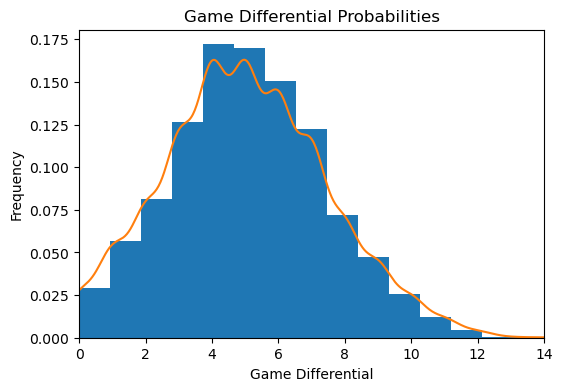

In [4]:

# initialize plot
fig, ax = plt.subplots(figsize=(6, 4))

# plot histogram
data['game_differential'].plot(kind='hist', density=True, bins=data['game_differential'].nunique())

# Kernel Density Estimation (KDE) computes underlying distribution
data['game_differential'].plot(kind='kde')

# Set X label
ax.set_xlabel('Game Differential')

# Set range of X-axis
ax.set_xlim(data['game_differential'].min(), data['game_differential'].max())

# Change Y label
ax.set_ylabel('Frequency')

# Set plot title
ax.set_title('Game Differential Probabilities')

# Display title
plt.show()

<!-- <a id="3"></a> <br> -->
## Elo Rating

Elo ratings are used to calculate the relative skill levels of players in zero-sum games such as tennis. The Elo rating will change as the athlete plays more games. Players with more matches played will have a more accurate rating. If a players match score exceeds their predicted score, their rating increases, if it falls short of their expected score, their rating decreases.

<!-- <a id="4"></a> <br> -->
### Initial Elo Ratings

Elo ratings start at 1500 for each player and will be changed after games are played.

In [6]:
def initialize_elo(df):
    """
    Initialize Elo ratings as 1500 for all players.

        Parameters:
            df (pd.DataFrame): Data set.

        Returns:
            elo_rating (pd.DataFrame): Data set of players Elo ratings.
            starting_elo (dict): Dictionary with player id and their Elo rating.
    """
    unique_player_ids = set(list(df["winner_id"].unique()) + list(df["loser_id"].unique()))

    elo_dict = {'player_id': list(unique_player_ids), "rating": [1500] * len(unique_player_ids)}

    starting_elo = dict(zip(elo_dict["player_id"], elo_dict["rating"]))

    elo_rating = pd.DataFrame(elo_dict)
    
    return elo_rating, starting_elo

## Win Margin Multiplier

The win margin multplier originates from a Nate Silver interview discussing win margin in Elo rating. [1] 

There are multiple ways to add a win multiplier to a match. Two popular methods include a nearly linear model and a natural logarithm model. Famous statistician Nate Silver uses a natural logarithm function for his NFL Elo ratings, and a nearly linear function for his NBA Elo ratings.

<a id="11"></a> <br>
## Functions for Elo Ratings

We now introduce functions which will be used to calculate the Elo ratings.

### Probability of Winning

The function below calculates the probability of a player winning given their Elo rating and their opponents.

In [6]:
def probability(p1, p2):
    """
    Probability of player 1 winning.

    Parameters:
        p1 (int): Player 1 Elo rating prior to the match.
        p2 (int): Player 2 Elo rating prior to the match.

    Returns:
        prob (float): Probability of player 1 winning.
    """
    prob = 1 / (1 + (10 ** ((p2 - p1) / 400)))
    return prob


### Update Elo Ratings

Updates the players Elo rating using the specified input parameters. "Score" is 1 for win or 0 for loss. "Expected" is the probability of the player winning.

In [7]:
def update_elo(rating, k_factor, score, expected):
    """
    Update Elo rating using new information.

        Parameters:
            rating (float): Elo rating of the given player.
            k_factor (float): K-factor for the given player.
            score (int): True score.
            expected (float): Expected score. (this expected value is calculated in the probability() function above)

        Returns:
            updated_elo (dict): Updated Elo rating.
    """
    updated_elo = rating + k_factor * (score - expected)
    return updated_elo

### Win Multiplier

The second part of the win multiplier equation takes into consideration the Elo 
rating of each player in the match. It assigns more weight to matches where Elo ratings are 
close, and assigns less weight to matches where the ratings are not close. Therefore, Elo ratings
are affected less when the difference in the players ratings is large.

In [8]:
def win_margin_multiplier(multiplier_function, point_diff, elo_winner, elo_loser, denominator):
    """
    Win multiplier using either a natural logarithm, linear function or no multiplier.

        Parameters:
            multiplier_function (str): Type of win multiplier function.
            point_diff (int): Difference in the amount of games won by each player.
            elo_winner (float): Elo rating of the winner.
            elo_loser (float): Elo rating of the loser.
            denominator (float): Denominator value of win multiplier.

        Returns:
            win_mult (float): The value for the win multiplier.
    """
    if multiplier_function == 'ln':
        win_mult = np.log((point_diff / denominator) + 1) * (2.2 / ((elo_winner - elo_loser) * 0.001 + 2.2))

    elif multiplier_function == 'linear':
        win_mult = ((point_diff ** 0.5) / denominator) * (2.2 / ((elo_winner - elo_loser) * 0.001 + 2.2))

    return win_mult

<a id="15"></a> <br>
### K-Factor

Next, we will need to get the number of games each player has played in the training data, as well as, in the testing data. These values will be used in the K-Factor calculation within the Elo rating. 

The K-Factor places a cap on the number of points a player can win or lose from a match. The K-Factor is critical in ensuring an accurate rating. A K-Factor measures how strongly a match will affect a players rating. A small value allows for a smaller change in rating, a large value allows for larger changes.

A K-Factor of 32 is a typical value that is often used to reduce complexity. However, changing the value for each player leads to more accurate results because we are able to know the number of matches used to build the Elo ratings, and the number of matches that will be played in the future. Knowing the number of future matches that will be played gives an estimate of the maximum number of points a player can win or lose in the upcoming tournament.

First, we will obtain the number of matches played in the training data, and the number of matches that will be played in the testing/evaluation data.

In [9]:
def games_played(df, evaluation=False):
    """
    Get number of matches each player played in the data set.

        Parameters:
            df (pd.DataFrame): Data set.
            evaluation (Boolean): Whether or not the calculation is for the training data or evaluation data.
                The structure of the evaluation data is different than the training data.

        Returns:
            player_games (Counter): Number of games played for each player.
    """
    if not evaluation: 
        # Series of the player 1 and player 2 ids for each game
        ids = pd.concat([df["winner_id"], df['loser_id']])

    elif evaluation:

        # Series of the player 1 and player 2 ids for each game
        ids = pd.concat([df['player_1'], df['player_2']])

    player_games = Counter(ids)
    
    return player_games

The function below can account for both a game differential (win margin) and no game differential.

In [10]:
def k_fact_win(player_id, num_games_training, num_games_evaluation, win_mult):
    """
    Calculates the K-Factor for given player.

        Parameters:
            player_id (int): Id of the player of interest.
            num_games_training (Counter): Number of games the player played in the training data.
            num_games_evaluation (Counter): Number of upcoming games the player will play in the evaluation data.
            win_mult (float): The value for the win multiplier.

        Returns:
            k_factor (float): K-factor for the given player.
    """
    
    # Number of games used to get Elo rating
    ne = num_games_training[player_id]

    # Number of games to be played in evaluation data
    m = num_games_evaluation[player_id]

    # Accounts for win multiplier
    if win_mult == 'None':

        # Calculate K-Factor with no win multiplier
        k_factor = 800 / (ne + m)

    else:

        # Calculate K-Factor with win multiplier
        k_factor = win_mult * (800 / (ne + m))

    return k_factor

When I was training my model on the training data, I was confused why the number of games played by the player in the training data(considered to be the games already played and used to calculate the Elo score of the player) and the games to be played (upcoming) by the player in the evaluation data is considered.
If we consider the first match this function receives, the players haven't played any match before (in the data) and still we sum the total matches in training and evaluation data.
This is because K-factor doesn't depend upon the sequence of games the player would play; rather it depends on the total number of matches the player has played or will play i.e. THE TOTAL NUMBER OF MATCHES THE PLAYER APPEARS IN. 

This is done to stabilize the Elo update:  
      • A player who plays fewer total matches gets a higher K → Elo updates more (we’re less sure about them).  
      • A player with many matches → smaller K → Elo updates less (more stable rating).  
So the K-factor depends on total match count — not when they occur.

### Calculate Elo Ratings

Uses functions defined above to calculate and update Elo ratings based on the given
data.

In [11]:
def get_elo(df, test_data, win_multiplier='ln', denom=1, production=False):
    """
    Input original Elo ratings and update the ratings using the match data.

        Parameters:
            df (pd.DataFrame): Data set.
            test_data (pd.DataFrame): Testing data set.
            win_multiplier (str): Type of win multiplier function.
            denom (float): Denominator value of win multiplier.
            production (Boolean): Whether or not we are using the evaluation data to make predictions.

        Returns:
            elo_rating (pd.DataFrame): Data set of players Elo ratings.
    """
    # DataFrame, dict
    elo_rating, starting_elo = initialize_elo(df)
    updated_elo = starting_elo.copy()

    match_list = list(zip(df["winner_id"], df["loser_id"]))
    
    for i, match in enumerate(match_list):
        p1 = match[0]
        p2 = match[1]

        num_games_training = games_played(df)

        num_games_testing = games_played(test_data, evaluation=production)

        if win_multiplier == 'None':
            
            p1_k = k_fact_win(p1, num_games_training, num_games_testing, win_multiplier)
            p2_k = k_fact_win(p2, num_games_training, num_games_testing, win_multiplier)

        else:

            win_mul = win_margin_multiplier(win_multiplier, df.loc[i, "game_differential"], updated_elo[p1], updated_elo[p2], denom)
            p1_k = k_fact_win(p1, num_games_training, num_games_testing, win_mul)
            p2_k = k_fact_win(p2, num_games_training, num_games_testing, win_mul)

        expected_p1 = probability(updated_elo[p1], updated_elo[p2])
        expected_p2 = probability(updated_elo[p2], updated_elo[p1])

        new_p1 = update_elo(updated_elo[p1], p1_k, 1, expected_p1)
        new_p2 = update_elo(updated_elo[p2], p2_k, 0, expected_p2)

        updated_elo[p1] = new_p1
        updated_elo[p2] = new_p2

    elo_rating["current_elo"] = updated_elo.values()
    del elo_rating["rating"]
    elo_rating = elo_rating.set_index("player_id")

    return elo_rating

<a id="17"></a> <br>
## Evaluate Prediction Accuracy

Function to evaluate prediction accuracy.

In [12]:
def evaluate_predictions(df, elo_rating):
    """
    Evaluate prediction accuracy.

        Parameters:
            df (pd.DataFrame): Data set.
            elo_rating (pd.DataFrame): Data set of players Elo ratings.

        Returns:
            accuracy (float): Prediction accuracy.
    """
    match_list = list(zip(df["winner_id"], df["loser_id"]))

    predictions = list()

    for match in match_list:
        p1 = match[0]
        p2 = match[1]

        expected_p1 = probability(elo_rating.loc[p1]['current_elo'], elo_rating.loc[p2]['current_elo'])
        predictions.append(expected_p1)

    rounded_preds = [round(pred) for pred in predictions]

    accuracy = sum(rounded_preds) / len(rounded_preds)

    return accuracy

<a id="18"></a> <br>
## Cross-Validation

Cross validation is used to find the optimal win multiplier function and it's corresponding denominator.

We need to perform cross validation carefully as we can not expose data from the testing
data in the training data. The ratings of the player needs to be calculated based
only on the given training data set. You can not use the results of the matches 
in the testing data. Therefore, we need to create the folds and calculate these 
stats for each fold. With Elo rating there is no need for inputs (x) and a target 
variable (y) like there is in typical cross validation. Therefore, we can just 
split the data into training and testing.

In [7]:
def get_folds(df, n_folds=5, random_state=42):
    """
    Splits data into multiple folds.

        Parameters:
            df (pd.DataFrame): Data set.
            n_folds (int): Number of folds to split original data set into.
            random_state (int): Used to reproduce results

        Returns:
            train_data (pd.DataFrame): Training data.
            test_data (pd.DataFrame): Testing data.
    """
    
    train_data = []
    test_data = []

    for fold in range(n_folds):
        train, test = train_test_split(df, train_size=0.7, random_state=random_state)

        train.reset_index(inplace=True, drop=True)
        test.reset_index(inplace=True, drop=True)

        train_data.append(train)
        test_data.append(test)

    return train_data, test_data

<a id="19"></a> <br>
## Fill in Missing Ratings

Some players in the testing data set may not have any observations in training based on the way the data was split.
Therefore, we need to input their rating as 1500 if they do not have a rating already.

In [14]:
def fill_missing_elo(unique_player_ids, elo_rating):
    """
    Fill in data for players with missing ratings in the testing data.

        Parameters:
            unique_player_ids (set): Unique player ids in the data.
            elo_rating (pd.DataFrame): Data set of players Elo ratings.

        Returns:
            elo (pd.DataFrame): Data set of players Elo ratings.
    """

    # Players with updated Elo ratings
    player_id_elo = set(elo_rating.index.values)

    # Players without updated Elo ratings
    no_elo = [item for item in unique_player_ids if item not in player_id_elo]

    # Dictionary of players without Elo rating and the initial Elo rating of 1500
    no_elo_dict = {'player_id': no_elo, 'current_elo': [1500] * len(no_elo)}

    # Create DataFrame of Elo rating with all 1500
    no_elo_df = pd.DataFrame(no_elo_dict)

    # Set index to player id
    no_elo_df.set_index('player_id', inplace=True)

    # Append the initial Elo ratings for players without an updated Elo rating
    # elo = elo_rating.hs(no_elo_df)
    elo = pd.concat([elo_rating, no_elo_df], axis=0)

    return elo

<a id="20"></a> <br>
## Tune Win Multiplier

This function is used to find the optimal type of win multiplier (Natural Logarithm,
Linear, or None) and their corresponding optimal win margin multiplier denominators.

In [8]:
def tune_parameters(train_data, test_data, win_multiplier, denominator):
    """
    Find the optimal type of win multiplier and corresponding optimal win margin multiplier denominators.

        Parameters:
            train_data (pd.DataFrame): Training data.
            test_data (pd.DataFrame): Testing data.
            win_multiplier (str): Type of win multiplier function.
            denominator (array): Array of denominator values to test.

        Returns:
            average_accuracy (float): Average prediction accuracy.
    """
    
    unique_player_ids = set(list(data['winner_id'].unique()) + list(data['loser_id'].unique()))

    if win_multiplier == "None":
        accuracy_cv = []

        for j in range(len(train_data)):
            # in get_elo(), elo of just players in train_data are evaluated. Not the players in test_data.
            elo_rating = get_elo(train_data[j], test_data[j], win_multiplier)
            # to tackle the problem stated above, we have do the following:
            elo = fill_missing_elo(unique_player_ids, elo_rating)
            
            accuracy = evaluate_predictions(test_data[j], elo)
            accuracy_cv.append(accuracy)
            
        average_accuracy = np.mean(accuracy_cv)

    elif win_multiplier == 'ln' or win_multiplier == 'linear':
        denom_accuracy = []

        for denom in denominator:
            accuracy_cv = []

            for j in range(len(train_data)):
                
                elo_rating = get_elo(train_data[j], test_data[j], win_multiplier, denom)
                elo = fill_missing_elo(unique_player_ids, elo_rating)
                
                accuracy = evaluate_predictions(test_data[j], elo)
                accuracy_cv.append(accuracy)

            denom_accuracy.append(np.mean(accuracy_cv))

        accuracy_dict = dict(zip(denominator, denom_accuracy))
        average_accuracy = pd.Series(accuracy_dict)

    return average_accuracy

<a id="21"></a> <br>
## Set Optimal Win Multiplier

Use functions to get Elo ratings and find best win multiplier and its optimal denominator value.

In [16]:
start = time.time()
training_data, testing_data = get_folds(data, n_folds=5, random_state=42)

ln_multiplier_accuracy = tune_parameters(training_data, testing_data, "ln", denominator=np.arange(0.5, 4.5, 0.5))
linear_multiplier_accuracy = tune_parameters(training_data, testing_data, "linear", denominator=np.arange(0.5, 4.5, 0.5))
no_multiplier_accuracy = tune_parameters(training_data, testing_data, "None", denominator=1)

print(f'Natural Logarithm Multiplier Accuracy:\n {ln_multiplier_accuracy}\n')
print(f'Linear Multiplier Accuracy:\n {linear_multiplier_accuracy}\n')
print(f'No Win Multiplier Accuracy:\n {no_multiplier_accuracy}\n')

ln_max_denom = ln_multiplier_accuracy.idxmax()
linear_max_denom = linear_multiplier_accuracy.idxmax()

max_accuracy_values = [ln_multiplier_accuracy.max(), linear_multiplier_accuracy.max(), no_multiplier_accuracy.max()]

best_win_multiplier = max_accuracy_values.index(max(max_accuracy_values))

if best_win_multiplier == 0:
    production_win_multiplier = 'ln'
    production_denominator = ln_max_denom

elif best_win_multiplier == 1:
    production_win_multiplier = 'linear'
    production_denominator = linear_max_denom

elif best_win_multiplier == 2:
    production_win_multiplier = 'None'
    production_denominator = 'None'

print(f'\nOptimal Win Multiplier: {production_win_multiplier}\n')
print(f'Optimal Win Multiplier Denominator: {production_denominator}')

print("Time taken={}".format(time.time()-start))

Natural Logarithm Multiplier Accuracy:
 0.5    0.544656
1.0    0.540996
1.5    0.538799
2.0    0.538799
2.5    0.539531
3.0    0.538067
3.5    0.545388
4.0    0.545388
dtype: float64

Linear Multiplier Accuracy:
 0.5    0.543924
1.0    0.537335
1.5    0.538067
2.0    0.536603
2.5    0.544656
3.0    0.541728
3.5    0.540996
4.0    0.539531
dtype: float64

No Win Multiplier Accuracy:
 0.5431918008784773


Optimal Win Multiplier: ln

Optimal Win Multiplier Denominator: 3.5
Time taken=398.02680921554565


<a id="22"></a> <br>
## Make Predictions

Predict win probabilities for evaluation data.

In [18]:
# Get Elo rating using training data, use production = True
elo_ratings = get_elo(data, evaluation_data, production_win_multiplier, production_denominator, production=True)

def predict_evaluation_data(eval_data, elo_rating):
    """
    Make predictions using evaluation data.

        Parameters:
            eval_data (pd.DataFrame): Data that is used to evaluate the model.
            elo_rating (pd.DataFrame): Elo ratings of the players based on the training data.

        Returns:
            evaluation_data (pd.DataFrame): Data that is used to evaluate the model with the player_1_win_probability
                column updated.
    """

    # Matches in evaluation data
    match_list = list(zip(eval_data['player_1'], eval_data['player_2']))

    # Empty list to append predictions to
    prediction = []

    # For each match in evaluation data
    for match in match_list:

        # Player 1 id
        p1 = match[0]

        # Player 2 id
        p2 = match[1]

        # Expected score for win and lose players before matches
        expected_p1 = probability(elo_rating.loc[p1]['current_elo'], elo_rating.loc[p2]['current_elo'])

        # Append prediction to list
        prediction.append(expected_p1)

    # Fill column with player1 win probabilities
    eval_data['player_1_win_probability'] = prediction

    return eval_data


# Make predictions
evaluation_data = predict_evaluation_data(evaluation_data, elo_ratings)

# Save as csv file
evaluation_data.to_csv(f'predictions.csv', index=False)

Once we've trained the Elo ratings using the training data (data), we use them as-is to predict outcomes in the evaluation_data.  
• Elo ratings are updated only during training (within get_elo(...)).  
• During prediction, we're simply comparing the final Elo scores from training.  
• There is no update in elo_ratings based on whether our prediction was right or wrong. That would require a second update step (which isn’t implemented here).  
  
  
But why?  

"During prediction, Elo scores are not updated because the actual match outcomes are still unknown. The model uses Elo ratings trained from historical data to estimate the probability of a player winning future matches. Updating a player's Elo score based on a prediction would wrongly assume that the prediction is always correct, which could introduce bias and distort future predictions. Instead, the Elo ratings remain fixed during prediction so that model accuracy can be objectively evaluated by comparing the predicted outcomes to the actual results. Only during training or after observing real outcomes should Elo ratings be updated."  ~ ChatGPT

Let's understand this easily:
1. Let's assume the a match of player A and player B
2. Our model "predicted" that player A wins.
3. After this, we increase Elo score of player A and decrease the same for player B
4. In the next matches of player A, he would perform better due to a higher, increased Elo score.
5. But, what if, in reality, he didn't win the first match.
6. This incorrect update would misrepresent both players' strengths, potentially leading to false predictions in their future matches — and even skewing Elo scores of players they later compete against.  

This is why we don't update the Elo scores of players when predicting.

## References
1. https://fivethirtyeight.com/features/introducing-nfl-elo-ratings/.
2. https://github.com/bradklassen/elo-rating-tennis-predictions